In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import vc_utils as vutils
import joblib


In [2]:
dataset = pd.read_pickle('../../geodata/results/01_master_building_dataset.pkl').reset_index()

In [3]:
maxvsh_cols    = dataset.columns[dataset.columns.str.contains('maxvsh')].tolist()
vaccess_cols   = dataset.columns[dataset.columns.str.contains('vwa')].tolist()
# mean_cols      = dataset.columns[dataset.columns.str.contains('mn')].tolist()
dist_cols      = dataset.columns[dataset.columns.str.contains('sum_')].tolist()
vconfig_cols   = np.setdiff1d(dataset.columns[np.where(dataset.columns == 'snt_0')[0][0]:np.where(dataset.columns == 'cmpx_gini')[0][0]+1].tolist(),dist_cols).tolist()[:-1]
id_cols        = ['ID_Geb','Stockwerk','FassPktX','FassPktY','FassPktZ']

dataset['unit_pano'] = dataset['unit_pano'].fillna(0)

In [4]:
# selected columns used in script
sel_cols    = maxvsh_cols+vaccess_cols+vconfig_cols + dist_cols+id_cols
income_cols = dataset.columns[np.where(dataset.columns == 'net_income')[0][0]:np.where(dataset.columns == 'deductPCT')[0][0]+1].tolist()

In [5]:
urban_form_names = dataset.groupby("NAME").size().sort_values().tail().index.tolist()
sel_10agglo_lst = dataset.groupby(['Agglo_Name','Rich_Nabr'])['GMDNR'].size().unstack().sort_values(by = 'R', ascending = False).head(10).index.tolist()

In [6]:
%%time

def dat_split(input_dat, id_gebs):
    X     = input_dat.loc[input_dat.ID_Geb.isin(id_gebs),:]
    X_rem = input_dat.loc[~input_dat.ID_Geb.isin(id_gebs),:]
    return X, X_rem

# Split National Stock into 
dat_gebs = (dataset.query('Stockwerk < 5')
                    .query('tprsn >= 100')
                    .query('net_income_ptp < 400')
                    )['ID_Geb'].unique()
dat, dat_ho = dat_split(dataset,dat_gebs)

dat_gebs = (dat
                .query('Agglo_Name in @sel_10agglo_lst')
                # .query('NAME in @urban_form_names')
                )['ID_Geb'].unique()
X, X_ho = dat_split(dat,dat_gebs)

print('Data with Associated Income >> N.Buildings: {} N.Communes {}'.format(dat.ID_Geb.nunique(), dat.GMDNAME.nunique()))
print('Data for Modeling >> N.Buildings: {} N.Communes {}'.format(X.ID_Geb.nunique(), X.GMDNAME.nunique()))


Data with Associated Income >> N.Buildings: 2568177 N.Communes 1254
Data for Modeling >> N.Buildings: 782053 N.Communes 365
CPU times: total: 20.3 s
Wall time: 20.3 s


In [110]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.svm import LinearSVR
from lightgbm import LGBMRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

dfs = []
models = [
        # ('LinearReg', LinearRegression()), 
        # ('LassoReg', Lasso()), 
        # ('GLMReg', TweedieRegressor(power=2, alpha=0.5, link='log')),
        # ('LGBM', LGBMRegressor()),
        # ('XGB', xgb.XGBRegressor( use_label_encoder = False, verbosity = 0,silent=True)),
        # ('RF',RandomForestRegressor(n_estimators = 100,verbose=3,n_jobs=-1)),
        ('NN6relu', MLPRegressor((6,), activation="relu",verbose=True, solver="adam", alpha=0)),
        ('NN6log', MLPRegressor((6,), activation="logistic",verbose=True, solver="adam", alpha=0.0)),
        ('NN100relu', MLPRegressor((100,), activation="relu",verbose=True, solver="adam", alpha=0.0)),
        ('NN100log', MLPRegressor((100,), activation="logistic",verbose=True, solver="adam", alpha=0.0))
]



In [14]:
#INIT RESULTS TABLE
res_train = pd.DataFrame()
res_test = pd.DataFrame()

In [9]:
# SPLIT DATAFRAME BY COMMUNE
model_feats    = maxvsh_cols+vaccess_cols+vconfig_cols+dist_cols
modeling_data = vutils.train_test_split_by_commune(X, model_feats, 'net_income_ptp', 1843, .2)
X_train, y_train, train_gebs = modeling_data['train']
X_test, y_test, test_gebs = modeling_data['test']

train_communes = X.query('ID_Geb in @train_gebs').GMDNAME.unique()
test_communes = X.query('ID_Geb in @test_gebs').GMDNAME.unique()

#RESCALE TRAIN SET VALUES
from sklearn.preprocessing import MinMaxScaler
model_feats    = maxvsh_cols+vaccess_cols+vconfig_cols+dist_cols
scaler = MinMaxScaler()
scaler.fit(X_train[model_feats])
joblib.dump(scaler, f"../../geodata/results/t10agglo_models/scaler_for_model.joblib")
X_train[model_feats] = scaler.transform(X_train[model_feats])
X_test[model_feats] = scaler.transform(X_test[model_feats])

print(f'{len(train_communes)} Num. of Train Communes ')
print(f'{len(test_communes)} Num. of Test Communes')

292 Num. of Train Communes 
73 Num. of Test Communes


In [122]:
name

'RF'

In [127]:
geoname = 'tr292ts73'
# train_table = pd.DataFrame(y_train)
test_table = pd.DataFrame(y_test)
# train_table['geoname'] = geoname
test_table['geoname'] = geoname

mods = {}
for name, model in models[:]:
    print(f'Starting {geoname},{name}')
    mod = model.fit(X_train, y_train)
    # joblib.dump(mod, f"../../geodata/results/t10agglo_models/{geoname}_{name}.joblib")
    # train_table[name] = mod.predict(X_train)
    test_table[name] = mod.predict(X_test[model_feats])
    mods[name] = mod
# res_train = pd.concat([res_train, train_table], axis = 0)
res_test = pd.concat([res_test, test_table], axis = 0)

Starting tr292ts73,NN6relu
Iteration 1, loss = 1111.19698974
Iteration 2, loss = 521.37986706
Iteration 3, loss = 489.42976638
Iteration 4, loss = 481.75632772
Iteration 5, loss = 479.74492493
Iteration 6, loss = 478.85804877
Iteration 7, loss = 478.35693688
Iteration 8, loss = 477.97615419
Iteration 9, loss = 477.71480927
Iteration 10, loss = 477.51369112
Iteration 11, loss = 477.37757210
Iteration 12, loss = 477.20701080
Iteration 13, loss = 477.14536601
Iteration 14, loss = 477.00940999
Iteration 15, loss = 476.93680813
Iteration 16, loss = 476.86690173
Iteration 17, loss = 476.80125404
Iteration 18, loss = 476.76630232
Iteration 19, loss = 476.68197456
Iteration 20, loss = 476.65337710
Iteration 21, loss = 476.61325802
Iteration 22, loss = 476.56111446
Iteration 23, loss = 476.53631402
Iteration 24, loss = 476.49846666
Iteration 25, loss = 476.47065809
Iteration 26, loss = 476.44108961
Iteration 27, loss = 476.40019829
Iteration 28, loss = 476.40758895
Iteration 29, loss = 476.3465

c:\Users\swietek\Miniconda3\envs\env_intel_sdb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 4006.82791399
Iteration 2, loss = 2721.57566467
Iteration 3, loss = 1654.52965302
Iteration 4, loss = 992.18242052
Iteration 5, loss = 657.52859768
Iteration 6, loss = 563.71717541
Iteration 7, loss = 547.27875226
Iteration 8, loss = 493.64723985
Iteration 9, loss = 477.25448528
Iteration 10, loss = 471.67203877
Iteration 11, loss = 466.95605382
Iteration 12, loss = 463.26009169
Iteration 13, loss = 460.24838380
Iteration 14, loss = 457.91736753
Iteration 15, loss = 456.03790276
Iteration 16, loss = 454.56075813
Iteration 17, loss = 453.36163396
Iteration 18, loss = 452.39809520
Iteration 19, loss = 451.57938001
Iteration 20, loss = 450.89776435
Iteration 21, loss = 450.28606216
Iteration 22, loss = 449.77850216
Iteration 23, loss = 449.33355126
Iteration 24, loss = 448.91741944
Iteration 25, loss = 448.53837577
Iteration 26, loss = 448.20250092
Iteration 27, loss = 447.91711935
Iteration 28, loss = 447.65797980
Iteration 29, loss = 447.37166308
Iteration 30, loss =

c:\Users\swietek\Miniconda3\envs\env_intel_sdb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 681.07212190
Iteration 2, loss = 473.46231715
Iteration 3, loss = 462.64769381
Iteration 4, loss = 456.53870724
Iteration 5, loss = 452.23342702
Iteration 6, loss = 448.83038210
Iteration 7, loss = 445.97210772
Iteration 8, loss = 443.74889331
Iteration 9, loss = 441.80087475
Iteration 10, loss = 440.10901462
Iteration 11, loss = 438.65777198
Iteration 12, loss = 437.39613248
Iteration 13, loss = 436.14667555
Iteration 14, loss = 435.16028976
Iteration 15, loss = 434.24890571
Iteration 16, loss = 433.31691154
Iteration 17, loss = 432.42947656
Iteration 18, loss = 431.68715389
Iteration 19, loss = 430.94368035
Iteration 20, loss = 430.22583217
Iteration 21, loss = 429.40444709
Iteration 22, loss = 428.97153639
Iteration 23, loss = 428.25630217
Iteration 24, loss = 427.68946976
Iteration 25, loss = 427.00340184
Iteration 26, loss = 426.61886094
Iteration 27, loss = 425.98336579
Iteration 28, loss = 425.49866246
Iteration 29, loss = 425.06637758
Iteration 30, loss = 42

c:\Users\swietek\Miniconda3\envs\env_intel_sdb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1040.09676243
Iteration 2, loss = 530.23587554
Iteration 3, loss = 476.01351974
Iteration 4, loss = 470.23613937
Iteration 5, loss = 464.47577058
Iteration 6, loss = 460.95081437
Iteration 7, loss = 458.51767971
Iteration 8, loss = 456.44261493
Iteration 9, loss = 454.64179478
Iteration 10, loss = 452.93552272
Iteration 11, loss = 451.35124189
Iteration 12, loss = 449.92268149
Iteration 13, loss = 448.52553163
Iteration 14, loss = 447.22159554
Iteration 15, loss = 445.99184631
Iteration 16, loss = 444.91977072
Iteration 17, loss = 443.95915607
Iteration 18, loss = 443.08905940
Iteration 19, loss = 442.30645856
Iteration 20, loss = 441.55518298
Iteration 21, loss = 440.92590520
Iteration 22, loss = 440.27472353
Iteration 23, loss = 439.68916971
Iteration 24, loss = 439.13500102
Iteration 25, loss = 438.60011408
Iteration 26, loss = 438.12582495
Iteration 27, loss = 437.66248003
Iteration 28, loss = 437.23781596
Iteration 29, loss = 436.79716923
Iteration 30, loss = 4

c:\Users\swietek\Miniconda3\envs\env_intel_sdb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [154]:
# modeling_data_lst = [(name, train_test_split_by_commune(grp, model_feats, 'net_income_ptp', 1843)) for name, grp in Xscaled.groupby('NAME')]

# # RUN MODEL ON GROUPS
# for geoname, modeling_data in modeling_data_lst:
#     # print('Starting {geoname}')
#     X_train, y_train, train_gebs = modeling_data['train']
#     X_test, y_test, test_gebs = modeling_data['test']
#     res_table = pd.DataFrame(y_train)
#     res_table['geoname'] = geoname
#     for name, model in models:
#         print(f'Starting {geoname},{name}')
#         clf = model.fit(X_train, y_train)
#         joblib.dump(clf, f"../../geodata/results/{geoname}_{name}.joblib")
#         res_table[name] = clf.predict(X_train)
#     res = pd.concat([res, res_table], axis = 0)

Starting Agrargemeinden,LinearReg
Starting Agrargemeinden,GLMReg
Starting Agrargemeinden,LGBM
Starting Agrargemeinden,XGB
Starting Gürtel der Grosszentren,LinearReg
Starting Gürtel der Grosszentren,GLMReg
Starting Gürtel der Grosszentren,LGBM
Starting Gürtel der Grosszentren,XGB
Starting Gürtel der Mittelzentren,LinearReg
Starting Gürtel der Mittelzentren,GLMReg
Starting Gürtel der Mittelzentren,LGBM
Starting Gürtel der Mittelzentren,XGB
Starting Mittelzentren,LinearReg
Starting Mittelzentren,GLMReg
Starting Mittelzentren,LGBM
Starting Mittelzentren,XGB
Starting Periurbane ländliche Gemeinden,LinearReg
Starting Periurbane ländliche Gemeinden,GLMReg
Starting Periurbane ländliche Gemeinden,LGBM
Starting Periurbane ländliche Gemeinden,XGB


In [152]:
mods

{'NN6relu': MLPRegressor(alpha=0, hidden_layer_sizes=(6,), verbose=True),
 'NN6log': MLPRegressor(activation='logistic', alpha=0.0, hidden_layer_sizes=(6,),
              verbose=True),
 'NN100relu': MLPRegressor(alpha=0.0, verbose=True),
 'NN100log': MLPRegressor(activation='logistic', alpha=0.0, verbose=True)}

In [128]:
model_results = {}
X_test['net_income_ptp'] = y_test
X_test['GMDNAME'] = X.loc[X_test.index,'GMDNAME']
runname = 'tr292ts73'

Xscaled = X.copy()
Xscaled[model_feats] = scaler.transform(X[model_feats])
for name in mods.keys():
    joblib.dump(mods[name], f"../../geodata/results/t10agglo_models/{runname}_{name}.joblib")
    model_results[name] = vutils.evaluate_model(mods[name], X_test, model_feats, 'net_income_ptp')
    Xscaled[name] = mods[name].predict(Xscaled[model_feats])

In [129]:
[(ix, model_results[ix]['rsquare_commune'].round(2) ) for ix in model_results.keys()]

[('NN6relu', 0.19), ('NN6log', 0.21), ('NN100relu', 0.25), ('NN100log', 0.25)]

In [14]:
# import joblib
# xgb_model   = joblib.load("../../geodata/results/t10agglo_t5urban_models/All_XGB.joblib")
# lr_model    = joblib.load("../../geodata/results/t10agglo_t5urban_models/All_LinearReg.joblib")
# rf_model    = joblib.load("../../geodata/results/t10agglo_t5urban_models/All_RF.joblib")
# lgbm_model  = joblib.load("../../geodata/results/t10agglo_t5urban_models/All_LGBM.joblib")
# lasso_model = joblib.load("../../geodata/results/t10agglo_t5urban_models/All_LassoReg.joblib")
# nn_model    = joblib.load("../../geodata/results/t10agglo_t5urban_models/All_NN.joblib")

In [15]:
# %time Xscaled['XGB']    = xgb_model.predict(Xscaled[model_feats])
# %time Xscaled['LinReg'] = lr_model.predict(Xscaled[model_feats])
# %time Xscaled['RF']     = rf_model.predict(Xscaled[model_feats])
# %time Xscaled['LassoReg']     = lasso_model.predict(Xscaled[model_feats])
# %time Xscaled['NN']     = nn_model.predict(Xscaled[model_feats])

CPU times: total: 2.91 s
Wall time: 448 ms
CPU times: total: 1.58 s
Wall time: 331 ms


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  95 out of 100 | elapsed:    4.6s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    4.8s finished


CPU times: total: 1min 21s
Wall time: 5.24 s
CPU times: total: 641 ms
Wall time: 360 ms
CPU times: total: 2.64 s
Wall time: 391 ms


In [16]:
# model_results = {}
# model_results['XGB']    = vutils.evaluate_model(xgb_model, Xscaled, model_feats, 'net_income_ptp')
# model_results['LinReg'] = vutils.evaluate_model(lr_model, Xscaled, model_feats, 'net_income_ptp')
# model_results['RF']     = vutils.evaluate_model(rf_model, Xscaled, model_feats, 'net_income_ptp')
# model_results['LassoReg']     = vutils.evaluate_model(lasso_model, Xscaled, model_feats, 'net_income_ptp')
# model_results['NN']     = vutils.evaluate_model(nn_model, Xscaled, model_feats, 'net_income_ptp')

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  95 out of 100 | elapsed:    4.4s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    4.5s finished


In [7]:
# import joblib
xgb_model   = joblib.load("../../geodata/results/t10agglo_t5urban_models/All_XGB.joblib")
lr_model    = joblib.load("../../geodata/results/t10agglo_t5urban_models/All_LinearReg.joblib")
rf_model    = joblib.load("../../geodata/results/t10agglo_t5urban_models/All_RF.joblib")
lgbm_model  = joblib.load("../../geodata/results/t10agglo_t5urban_models/All_LGBM.joblib")
lasso_model = joblib.load("../../geodata/results/t10agglo_t5urban_models/All_LassoReg.joblib")
nn_model    = joblib.load("../../geodata/results/t10agglo_t5urban_models/All_NN.joblib")

In [8]:
mods = dict(
    GLMReg_model    = joblib.load("../../geodata/results/t10agglo_models/tr292ts73_GLMReg.joblib"),
    XGB_model    = joblib.load("../../geodata/results/t10agglo_models/tr292ts73_XGB.joblib"),
    RF_model    = joblib.load("../../geodata/results/t10agglo_models/tr292ts73_RF.joblib"),
    LassoReg_model    = joblib.load("../../geodata/results/t10agglo_models/tr292ts73_LassoReg.joblib"),
    NN100log_model    = joblib.load("../../geodata/results/t10agglo_models/tr292ts73_NN100log.joblib"),
    LGBM_model    = joblib.load("../../geodata/results/t10agglo_models/tr292ts73_LGBM.joblib"),
    LR_model    = joblib.load("../../geodata/results/t10agglo_models/tr292ts73_LinearReg.joblib"))

In [9]:
model_feats    = maxvsh_cols+vaccess_cols+vconfig_cols+dist_cols

import joblib
scaler_4model   = joblib.load("../../geodata/results/t10agglo_models/scaler_for_model.joblib")

dat = dataset.copy()
dat[model_feats] = scaler_4model.transform(dat[model_feats])

In [10]:
for name in mods.keys():
    dataset[name] = mods[name].predict(dat[model_feats])

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  95 out of 100 | elapsed:   28.4s remaining:    1.4s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:   29.8s finished


In [11]:
import seaborn as sns

<Axes: ylabel='Proportion'>

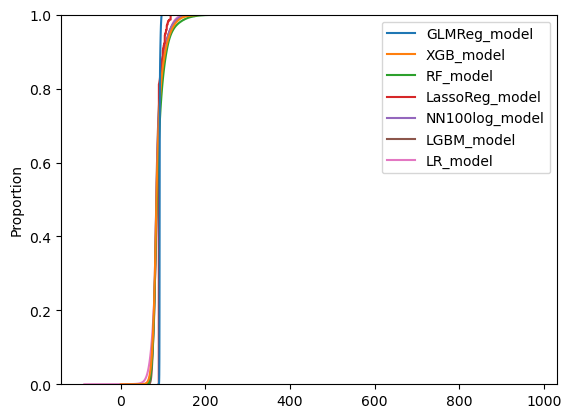

In [18]:
sns.ecdfplot(dataset[mods.keys()])

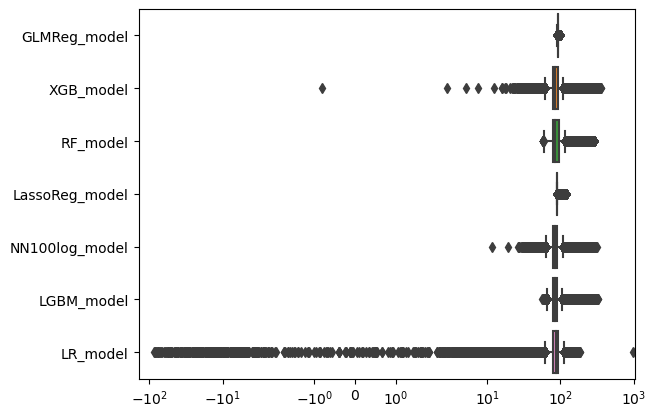

In [17]:
sns.boxplot(dataset[mods.keys()], orient = 'h')

plt.xscale('symlog')
# plt.ylim((0,10000))

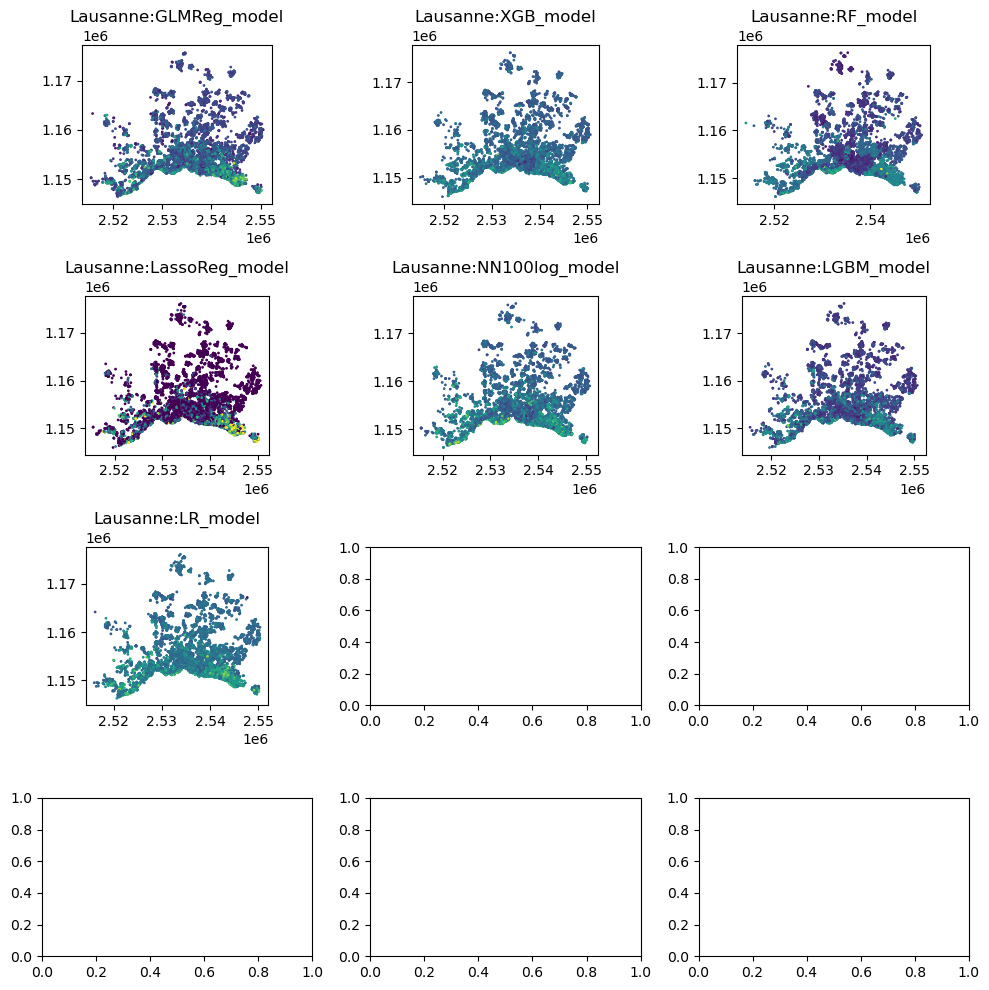

In [19]:
f, ax = plt.subplots(4,3, figsize = (10,10))
# ax = ax.flatten()

for ax,nm in zip(ax.flatten(),mods.keys()):
    dataset.query('Agglo_Name == "Lausanne"').sample(10000).plot(nm, markersize = 1, ax = ax)
    ax.set_title(f'Lausanne:{nm}')
# Xscaled.query('Agglo_Name == "Lausanne"').sample(10000).plot("LassoReg", markersize = 1, ax = ax[1])
# Xscaled.query('Agglo_Name == "Lausanne"').sample(10000).plot("GLMReg", markersize = 1, ax = ax[2])
# Xscaled.query('Agglo_Name == "Lausanne"').sample(10000).plot("LGBM", markersize = 1, ax = ax[3])
# Xscaled.query('Agglo_Name == "Lausanne"').sample(10000).plot("XGB", markersize = 1, ax = ax[4])
# Xscaled.query('Agglo_Name == "Lausanne"').sample(10000).plot("RF", markersize = 1, ax = ax[5])
plt.tight_layout()

In [132]:
mod_names = list(mods.keys())
Xsamp = Xscaled.loc[X_test.index,['net_income_ptp']+mod_names].sample(5000)
Xsamp['type'] = 'test'

Xsamp2 = Xscaled.loc[X_train.index,['net_income_ptp']+mod_names].sample(5000)
Xsamp2['type'] = 'train'

Xsamp = pd.concat([Xsamp, Xsamp2], axis = 0, ignore_index=True)

In [133]:
Xsamp = Xsamp.melt(id_vars=['net_income_ptp','type'])

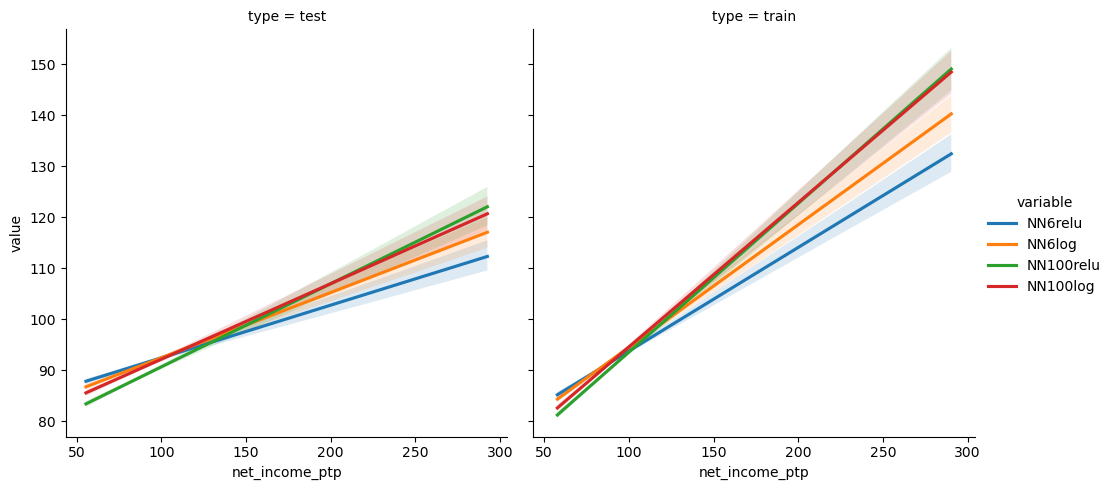

In [134]:
sns.lmplot(data=Xsamp, col='type', hue = 'variable', x = 'net_income_ptp', y= 'value', scatter=False)

In [92]:
ch_income = gpd.read_file('../../geodata/ch_districts/ch_income_per_commune_2018.gpkg')

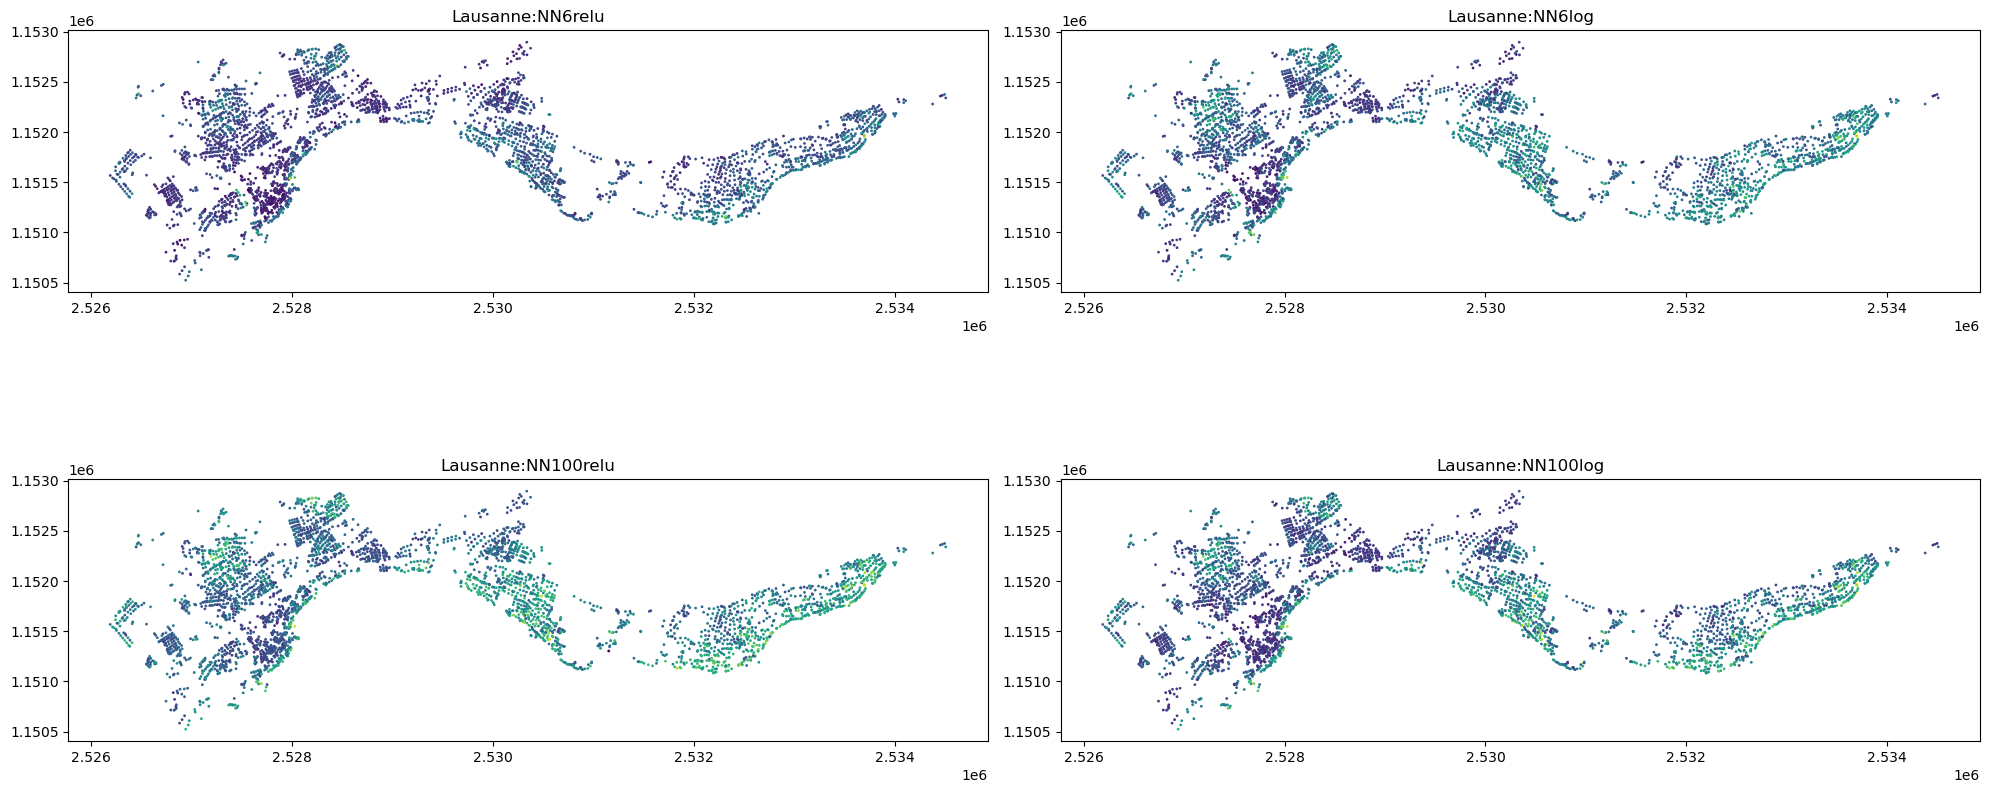

In [135]:
f, ax = plt.subplots(2,2, figsize = (20,10))
# ax = ax.flatten()
comms = ["Saint-Sulpice (VD)","Préverenges","Morges"]
for ax,nm in zip(ax.flatten(),mods.keys()):
    Xscaled.query('GMDNAME in @comms').plot(nm, markersize = 1, ax = ax)
    # ch_income.query('GMDNAME in @comms').plot("net_income_ptp", facecolor = 'none', ax = ax)

    ax.set_title(f'Lausanne:{nm}')
plt.tight_layout()

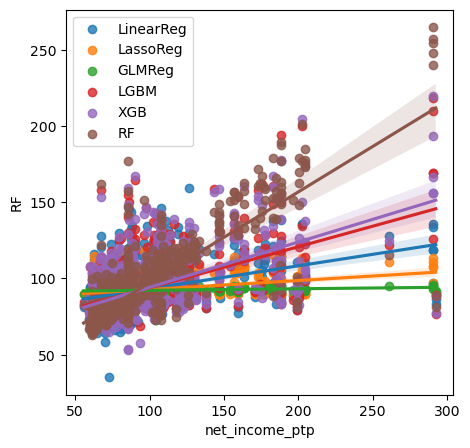

In [45]:
f, ax = plt.subplots(figsize = (5,5))

Xsamp = Xscaled.sample(1000)
for mod in model_results.keys():
    sns.regplot(data = Xsamp, x = 'net_income_ptp', y = mod, ax = ax, label = mod)
# sns.regplot(data = Xsamp, x = 'net_income_ptp', y = 'XGB', ax = ax, color = 'blue')
# sns.regplot(data = Xsamp, x = 'net_income_ptp', y = 'RF', ax = ax, color = 'red')
plt.legend()


C:\Users\swietek\AppData\Local\Temp\ipykernel_32308\630232253.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = Xscaled.corr().loc[model_feats,model_results.keys()].dropna()
c:\Users\swietek\Miniconda3\envs\env_intel_sdb\lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


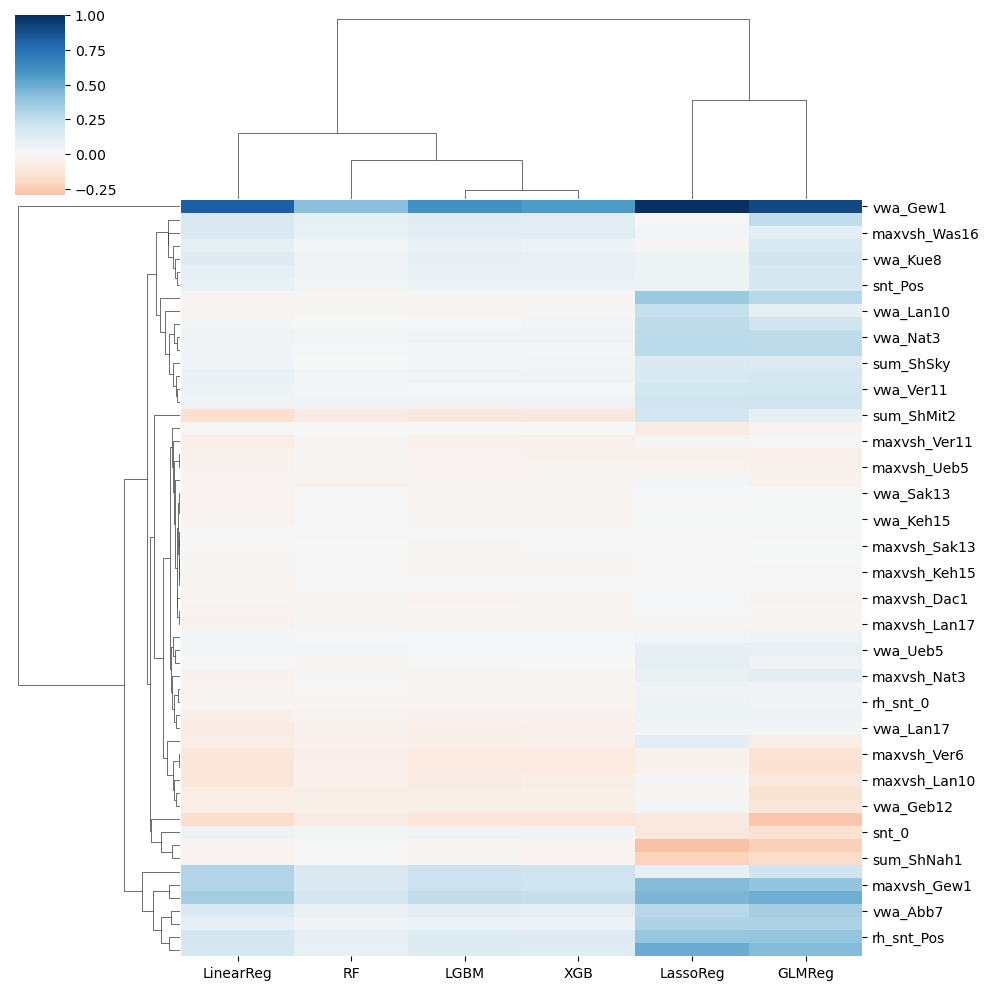

In [101]:
import seaborn as sns
cor = Xscaled.corr().loc[model_feats,model_results.keys()].dropna()
# cor = cor.mask(abs(cor)<.1)
sns.clustermap(cor, center=0, square =True, cmap = 'RdBu')
# sns.heatmap(cor)

In [102]:
tx_dataset = pd.read_csv(r"C:\Users\swietek\Documents\View\Swiss_View\Swiss_View\geodata\archive\trx_viewdata_feb10_matched.csv")
tx_dataset['unit_pano'] = 0

C:\Users\swietek\AppData\Local\Temp\ipykernel_32308\4122823773.py:1: DtypeWarning: Columns (15,23,30) have mixed types. Specify dtype option on import or set low_memory=False.
  tx_dataset = pd.read_csv(r"C:\Users\swietek\Documents\View\Swiss_View\Swiss_View\geodata\archive\trx_viewdata_feb10_matched.csv")


In [103]:
model_feats    = maxvsh_cols+vaccess_cols+vconfig_cols+dist_cols

import joblib
scaler_4model   = joblib.load("../../geodata/results/t10agglo_models/scaler_for_model.joblib")

In [104]:
trx = tx_dataset.copy()
trx[model_feats] = scaler_4model.transform(tx_dataset[model_feats])

In [105]:
for name in mods.keys():
    trx[name] = mods[name].predict(trx[model_feats])

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  95 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished


In [108]:
corr_cols = ['BAUJ', 'VOL_GVA', 'LAND', 'ZUST',
       'FREI', 'ZIMMER', 
        'SON_SOM', 'SON_WINT', 
        'LAERM_B_D', 'LAERM_B_N', 'LAERM_STR_D', 'LAERM_STR_N', 'DIST_HAUPTSTR',
        'DIST_BAHNL', 'DIST_SENDE', 'DIST_ATOM', 'DIST_HOCHSP', 'DIST_ZENTR',
        'DIST_SCHUL', 'DIST_SHOP', 'DIST_HALTEST', 'DIST_NAT', 'DIST_SEE',
        'DIST_FLUSS', 'OEV_GUET', 'DIFFBEV5REL', 'ERREICH.OEV.BESCH', 'ERREICH.OEV.BEW',
        'REISE.OEV.LOG', 'SEEANSTOSS', 'EK.KT.HOCH', 'EKST.TOTAL.HOCH']

C:\Users\swietek\AppData\Local\Temp\ipykernel_32308\1184827727.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = trx.corr().loc[corr_cols,mods.keys()]
c:\Users\swietek\Miniconda3\envs\env_intel_sdb\lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


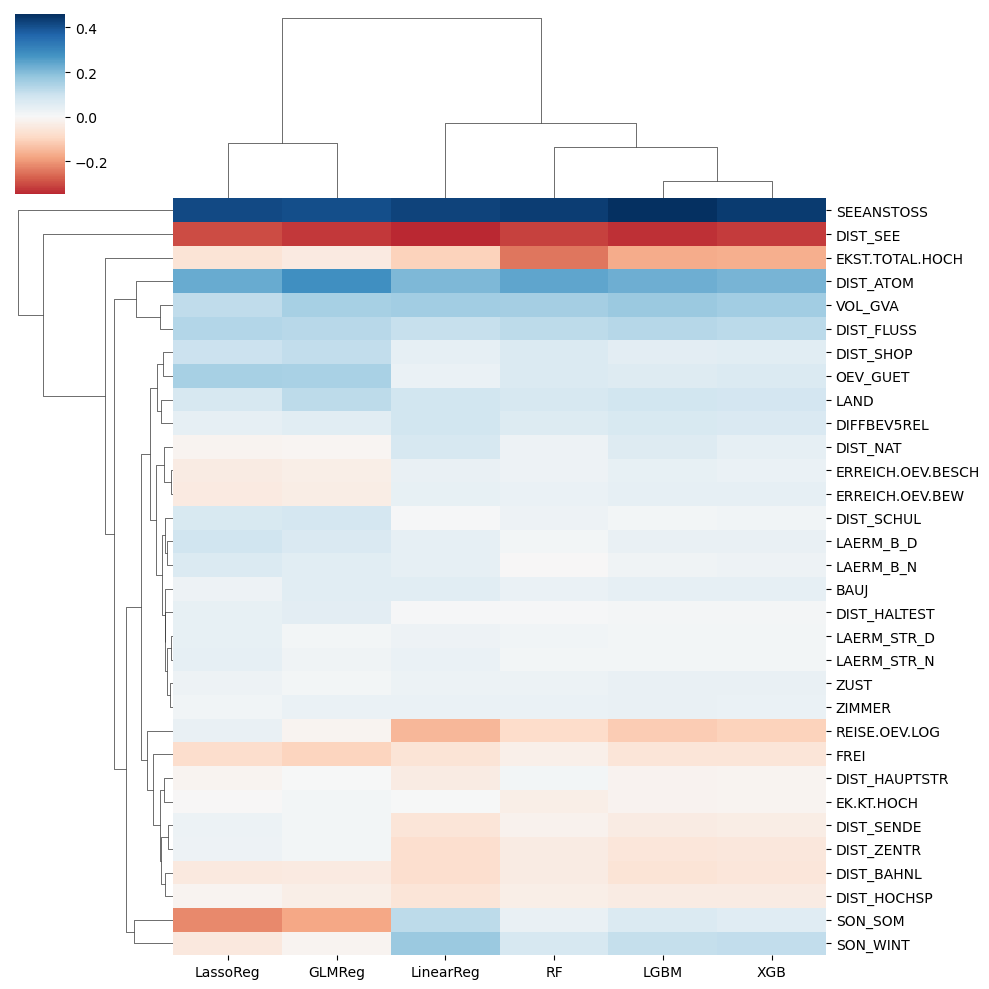

In [109]:
import seaborn as sns
cor = trx.corr().loc[corr_cols,mods.keys()]

sns.clustermap(cor, center=0, square =True,figsize=(10,10), cmap = 'RdBu')

In [143]:
X_sampled = Xscaled[model_feats].sample(100)
import shap
xgb_explainer = shap.KernelExplainer(mods['NN100log'].predict, X_sampled.reset_index(drop = True))
shap_values = xgb_explainer.shap_values(X_sampled)

X does not have valid feature names, but MLPRegressor was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with featur

In [68]:
rf_explainer = shap.TreeExplainer(rf_model)
shap_values = rf_explainer.shap_values(X_sampled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


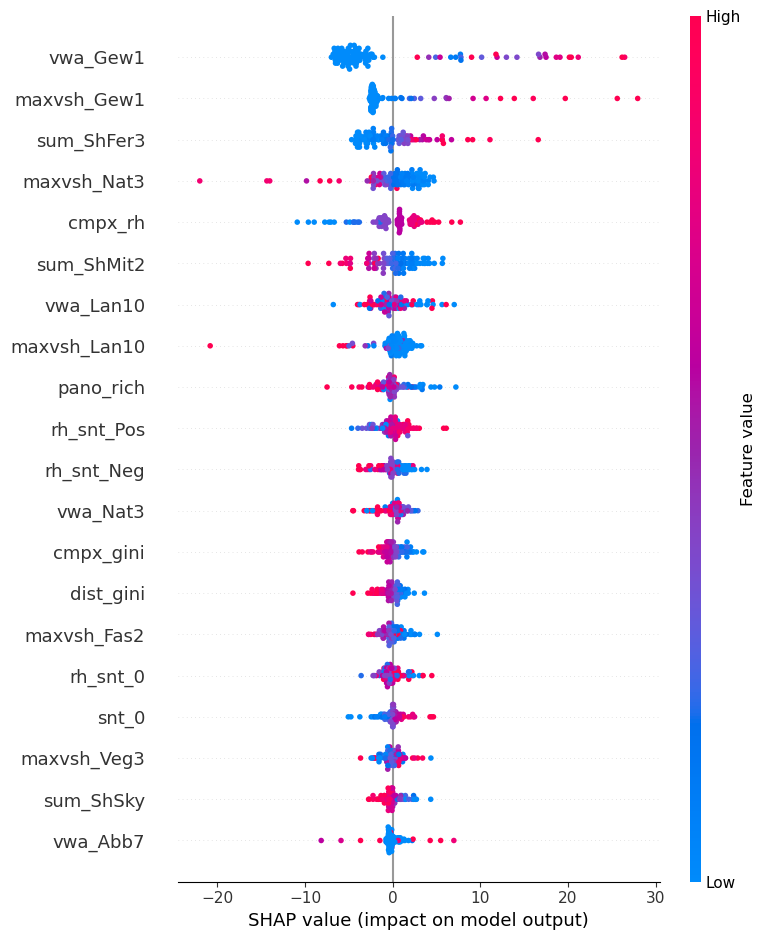

In [144]:
shap.summary_plot(shap_values, X_sampled)


<Axes: xlabel='NN6log', ylabel='NN100log'>

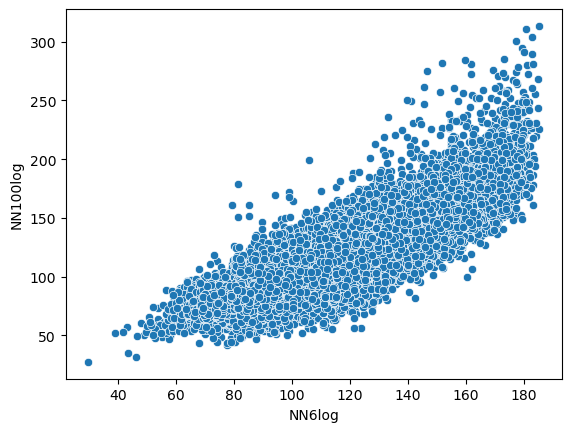

In [151]:
sns.scatterplot(data = Xscaled, x = 'NN6log', y = 'NN100log')

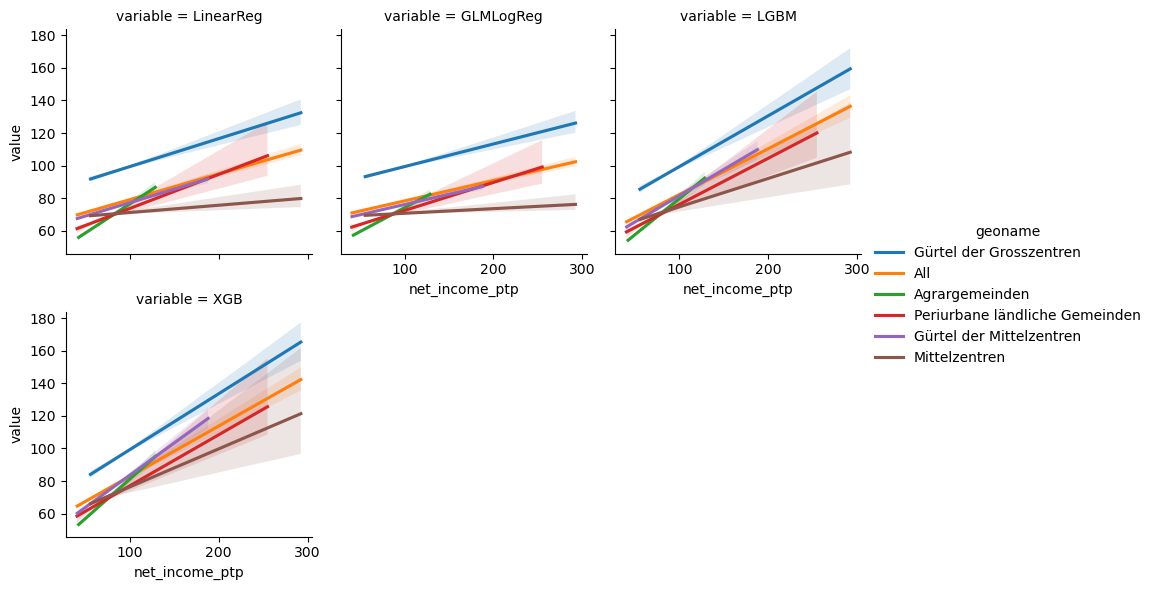

In [147]:
g = sns.FacetGrid(data = res.sample(10000).melt(id_vars=['net_income_ptp','geoname']), col = 'variable', hue='geoname', col_wrap=3)

g.map(sns.regplot, 'net_income_ptp','value', scatter= False).add_legend()

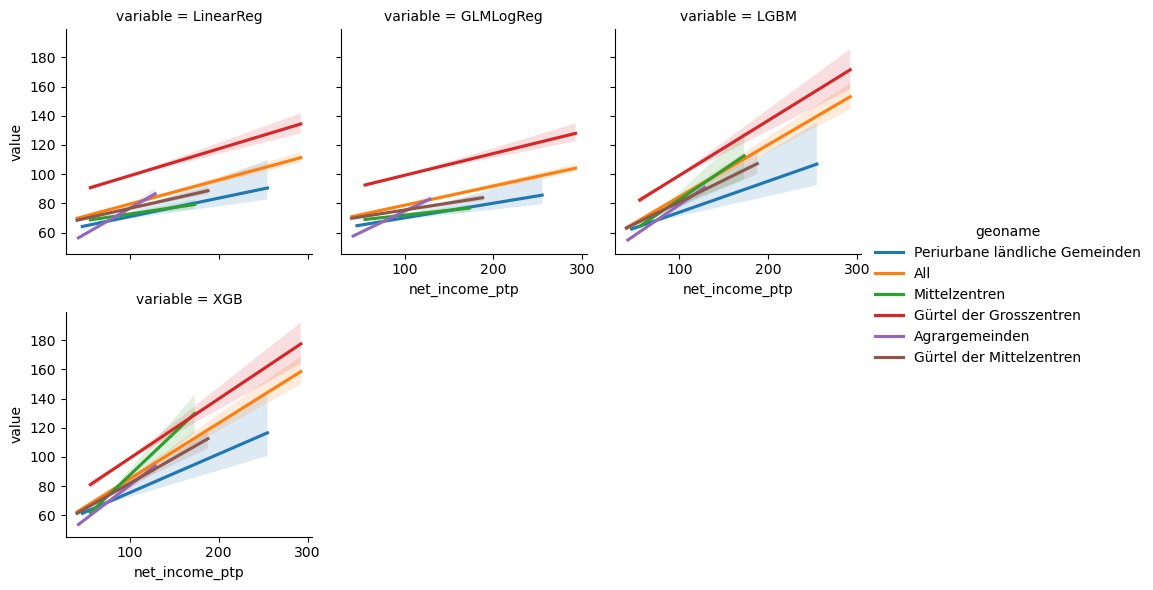

In [146]:
g = sns.FacetGrid(data = res.sample(10000).melt(id_vars=['net_income_ptp','geoname']), col = 'variable', hue='geoname', col_wrap=3)

g.map(sns.regplot, 'net_income_ptp','value', scatter= False).add_legend()

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd


def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners:param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier())
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['malignant', 'benign']
    for name, model in models:
        # kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        # cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        # this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
    return final